In [1]:
import torch
import torchvision
import numpy as np
import os
import torch.nn as nn
import torch.optim as optim
import shutil

from sympy.strategies.core import switch

from approx_attributes import *
import torch.nn.functional as F
from matplotlib.colors import LinearSegmentedColormap
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from huggingface_hub import hf_hub_download
from torch.utils.data import DataLoader
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
from captum.attr import InputXGradient,IntegratedGradients,Saliency
print(torch.__version__)
print(torchvision.__version__)

2.8.0+rocm6.4
0.23.0+rocm6.4


/home/benomin/PycharmProjects/BA-Approoximation-Feature-Attribution/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#model = torch.load("resnet18_cifar10_32x32_epoch30.pth",weights_only=False)
#model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
#model.to(device)
#model.eval()

In [3]:

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # 32x32x32
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)  # 32x32x32 -> 16x16x32 (nach MaxPool)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # 16x16x64 -> 8x8x64 (nach MaxPool)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*8*8, 256)  # 64*8*8 = 4096
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # Input: 32x32x3
        x = F.relu(self.conv1(x))                      # -> 32x32x32
        x = F.relu(self.conv2(x))                      # -> 32x32x32
        x = F.max_pool2d(x, 2)                         # -> 16x16x32
        x = F.relu(self.conv3(x))                      # -> 16x16x64
        x = F.max_pool2d(x, 2)                         # -> 8x8x64
        x = self.flatten(x)                            # -> 4096
        x = F.relu(self.fc1(x))                        # -> 256
        x = self.fc2(x)                                # -> 10
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)

if os.path.isfile("CifarModelCnn.pth"):

    state_dict = torch.load("CifarModelCnn.pth", map_location=torch.device(device))

    model.load_state_dict(state_dict)
    model.eval()


In [4]:

model2 = models.resnet18(num_classes=10)

model2.load_state_dict(torch.load("resnet18_cifar10.pth", map_location="cpu"))
model2.to(device)
model2.eval()

model3 = models.resnet50(weights=None, num_classes=10)
model3.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model3.maxpool = nn.Identity()


weights_path = hf_hub_download(repo_id="edadaltocg/resnet50_cifar10", filename="pytorch_model.bin")
state_dict = torch.load(weights_path, map_location="cpu")
model3.load_state_dict(state_dict)
model3.to(device)
model3.eval()



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentu

In [5]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010]
    )
])

cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(cifar_trainset, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=1, shuffle=False)

dataset = test_loader.dataset
cifar10_labels = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

In [6]:
def to_numpy_image(attr):
    """
    Bringt Attribution Map in Shape (H,W,C) für matplotlib.
    Erwartet Tensor oder numpy array in Form:
    - (C,H,W)
    - (H,W,C)
    - (3072,)
    - (1,C,H,W)
    """
    if isinstance(attr, torch.Tensor):
        attr = attr.detach().cpu().numpy()

    if attr.ndim == 1:  # flach: 3072
        attr = attr.reshape(3, 32, 32)

    if attr.ndim == 4:  # Batch-Format
        attr = attr.squeeze(0)  # -> (C,H,W)

    if attr.shape[0] == 3 and attr.ndim == 3:  # (C,H,W)
        attr = np.transpose(attr, (1, 2, 0))

    return attr

/home/benomin/PycharmProjects/BA-Approoximation-Feature-Attribution/.venv/lib/python3.12/site-packages/captum/attr/_core/saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2352166..2.7537313].
/home/benomin/PycharmProjects/BA-Approoximation-Feature-Attribution/.venv/lib/python3.12/site-packages/captum/attr/_core/input_x_gradient.py:118: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2352166..2.7537313].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255]

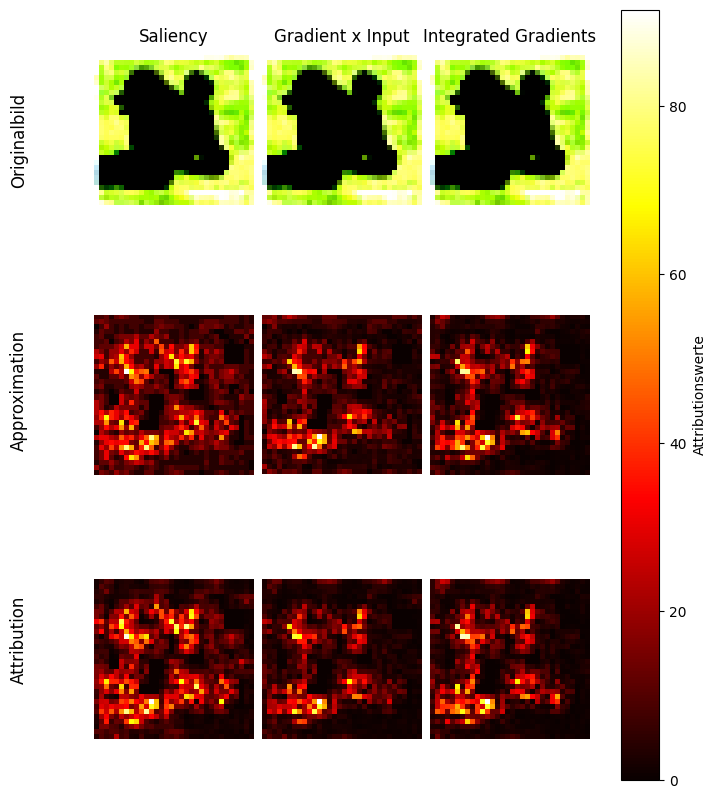

In [8]:
model = model
aa = ApproxAttribution(model)
sal = Saliency(model)
IxG = InputXGradient(model)
ig = IntegratedGradients(model)

idx = np.random.randint(0, len(dataset) - 1)

plt.style.use('default')

fig, axes = plt.subplots(3, 3, figsize=(8,10))
fig.set_facecolor('white')

axes[0, 0].set_title('Saliency')
axes[0, 1].set_title('Gradient x Input')
axes[0, 2].set_title('Integrated Gradients')

fig.text(0.02, 0.75, 'Originalbild', rotation=90, verticalalignment='center',fontsize=12)
fig.text(0.02, 0.5, 'Approximation', rotation=90, verticalalignment='center',fontsize=12)
fig.text(0.02, 0.25, 'Attribution', rotation=90, verticalalignment='center',fontsize=12)

cnt = 0
for i in range(3):
    img, label = dataset[idx]

    #attribution_map_real = ig.attribute(img.unsqueeze(0).float(), target=label,baselines=torch.zeros_like(img, dtype=torch.float)).detach().numpy()
    #attribution_map = to_numpy_image(aa.grad_approx(0.1,[img.unsqueeze(0)],label))
    #attribution_map_real = to_numpy_image(sal.attribute(img.unsqueeze(0).float().to(device), target=label))

    if i == 0:
        attribution_map = aa.grad_approx(0.0001, [img.unsqueeze(0)], target=label).reshape(3, 32, 32)
        attribution_map_real = sal.attribute(img.unsqueeze(0).float().to(device), target=label)
    elif i == 1:
        attribution_map = aa.grad_x_i_approx(0.0001, [img.unsqueeze(0)], target=label).reshape(3, 32, 32)
        attribution_map_real = IxG.attribute(img.unsqueeze(0).float().to(device), target=label)
    elif i == 2:
        attribution_map = aa.int_grad_approx(0.0001, [img.unsqueeze(0)], target=label).reshape(3, 32, 32)
        attribution_map_real = ig.attribute(img.unsqueeze(0).float().to(device), target=label,baselines=torch.zeros_like(img.unsqueeze(0), dtype=torch.float).to(device)) #.detach().cpu().numpy()


    attribution_map_real = attribution_map_real.squeeze().detach().cpu().numpy()  # shape: [3, # 32, 32]

    attr_vis = np.abs(attribution_map).max(axis=0)
    attr_real_vis = np.abs(attribution_map_real).max(axis=0)

    image_np = to_numpy_image(img)

    im = axes[0,i].imshow(image_np)
    axes[0,i].axis('off')

    im1 = axes[1,i].imshow(attr_vis, cmap='hot')
    axes[1,i].axis('off')

    im2 = axes[2,i].imshow(attr_real_vis, cmap='hot')
    axes[2,i].axis('off')

    cnt = cnt + 1

plt.subplots_adjust(wspace=0.05, hspace=0.1)
fig.colorbar(im1, ax=axes.ravel().tolist(), label='Attributionswerte')
#plt.tight_layout()
plt.savefig("mein_plot.png", bbox_inches='tight')
plt.show()

In [32]:
"""
high = 1.0
medium = 0.1
low = 1e-4





"""

'\nhigh = 1.0\nmedium = 0.1\nlow = 1e-4\n\n\n\n\n\n'

In [28]:
high = 1.0
mediumhigh = 0.5
medium = 0.01
low = 1e-4

def gen_data(h=high,method="Sal",filename="daten_sal.npz",size=10,baseline=None,model=model):
    aa = ApproxAttribution(model)
    sal = Saliency(model)
    IxG = InputXGradient(model)
    ig = IntegratedGradients(model)

    real = []
    approx = []
    idx =[]
    for i in range(size):
        idx.append(np.random.randint(0, len(dataset) - 1))

    for i in idx:
        img, label = dataset[i]
        if method == "Sal":
            approx.append(aa.grad_approx(h, [img.unsqueeze(0)], target=label).reshape(3, 32, 32))
            real.append(sal.attribute(img.unsqueeze(0).float().to(device), target=label).squeeze().detach().cpu().numpy())
        if method == "GxI":
            approx.append(aa.grad_x_i_approx(h, [img.unsqueeze(0)], target=label).reshape(3, 32, 32))
            real.append(IxG.attribute(img.unsqueeze(0).float().to(device), target=label).squeeze().detach().cpu().numpy())
        if method == "Int":
            approx.append(aa.int_grad_approx(h, [img.unsqueeze(0)], target=label).reshape(3, 32, 32))
            real.append(ig.attribute(img.unsqueeze(0).float().to(device), target=label).squeeze().detach().cpu().numpy())

    real_flat = [np.array(r).flatten() for r in real]
    approx_flat = [np.array(a).flatten() for a in approx]


    real_flat = np.array(real_flat)
    approx_flat = np.array(approx_flat)
    np.savez(filename, arr1=real_flat,arr2=approx_flat)

gen_data(h=high,method="Int",filename="ResNet50_Int_20_high.npz",size=20,model=model3)

In [29]:
gen_data(h=mediumhigh,method="Int",filename="ResNet50_Int_20_mediumhigh.npz",size=20,model=model3)

In [32]:
gen_data(h=high,method="GxI",filename="ResNet50_GxI_50_high.npz",size=50,model=model3)
gen_data(h=mediumhigh,method="GxI",filename="ResNet50_GxI_50_mediumhigh.npz",size=50,model=model3)

In [34]:
gen_data(h=low,method="Sal",filename="ResNet50_Sal_50_low.npz",size=50,model=model3)
gen_data(h=medium,method="Sal",filename="ResNet50_Sal_50_medium.npz",size=50,model=model3)
gen_data(h=high,method="Sal",filename="ResNet50_Sal_50_high.npz",size=50,model=model3)
gen_data(h=mediumhigh,method="Sal",filename="ResNet50_Sal_50_mediumhigh.npz",size=50,model=model3)

In [ ]:
gen_data(h=low,method="GxI",filename="ResNet18_GxI_50_low.npz",size=50,model=model2)
gen_data(h=medium,method="GxI",filename="ResNet18_GxI_50_medium.npz",size=50,model=model2)
gen_data(h=mediumhigh,method="GxI",filename="ResNet18_GxI_50_mediumhigh.npz",size=50,model=model2)
gen_data(h=high,method="GxI",filename="ResNet18_GxI_50_high.npz",size=50,model=model2)

In [ ]:
gen_data(h=low,method="Sal",filename="ResNet18_Sal_50_low.npz",size=50,model=model2)
gen_data(h=medium,method="Sal",filename="ResNet18_Sal_50_medium.npz",size=50,model=model2)
gen_data(h=mediumhigh,method="Sal",filename="ResNet18_Sal_50_mediumhigh.npz",size=50,model=model2)
gen_data(h=high,method="Sal",filename="ResNet18_Sal_50_high.npz",size=50,model=model2)

In [ ]:
gen_data(h=low,method="Int",filename="CNN_Int_20_low.npz",size=20,model=model)
gen_data(h=medium,method="Int",filename="CNN_Int_20_medium.npz",size=20,model=model)
gen_data(h=mediumhigh,method="Int",filename="CNN_Int_20_mediumhigh.npz",size=20,model=model)
gen_data(h=high,method="Int",filename="CNN_Int_20_high.npz",size=20,model=model)

In [ ]:
gen_data(h=low,method="GxI",filename="CNN_GxI_50_low.npz",size=50,model=model)
gen_data(h=medium,method="GxI",filename="CNN_GxI_50_medium.npz",size=50,model=model)
gen_data(h=mediumhigh,method="GxI",filename="CNN_GxI_50_mediumhigh.npz",size=50,model=model)
gen_data(h=high,method="GxI",filename="CNN_GxI_50_high.npz",size=50,model=model)

gen_data(h=low,method="Sal",filename="CNN_Sal_50_low.npz",size=50,model=model)
gen_data(h=medium,method="Sal",filename="CNN_Sal_50_medium.npz",size=50,model=model)
gen_data(h=mediumhigh,method="Sal",filename="CNN_Sal_50_mediumhigh.npz",size=50,model=model)
gen_data(h=high,method="Sal",filename="CNN_Sal_50_high.npz",size=50,model=model)

In [ ]:
####################################################################################################
gen_data(h=low,method="Int",filename="ResNet18_Int_20_low.npz",size=20,model=model2)
gen_data(h=medium,method="Int",filename="ResNet18_Int_20_medium.npz",size=20,model=model2)
gen_data(h=mediumhigh,method="Int",filename="ResNet18_Int_20_mediumhigh.npz",size=20,model=model2)
gen_data(h=high,method="Int",filename="ResNet18_Int_20_high.npz",size=20,model=model2)
####################################################################################################

In [25]:
from captum.attr import InputXGradient,IntegratedGradients,Saliency
from scipy import stats
from approx_attributes import *
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity


data = np.load("ResNet50_Int_20_medium.npz")
real = data["arr1"]
approx = data["arr2"]
print(real.shape)
print("Pearson-Correlation:",np.mean(np.corrcoef(real,approx)))
roh,p = stats.spearmanr(real.ravel(), approx.ravel())
print("Rank-Correlation:",roh)
print("Gesamt-MSE:", mean_squared_error(real,approx))
cos_total = cosine_similarity(real, approx)
print("Gesamt-Cosine Similarity:", cos_total)

(20, 3072)
Pearson-Correlation: 0.04521190585910793
Rank-Correlation: 0.9110776552075542
Gesamt-MSE: 0.02908332087099552
Gesamt-Cosine Similarity: [[ 9.75825965e-01 -6.15905151e-02  3.77173126e-02  8.04384276e-02
  -2.38715652e-02  2.89996080e-02 -1.17279729e-02  2.93049915e-03
   3.94096673e-02  2.41789240e-02  4.21807356e-03  6.56841276e-03
  -7.40700867e-03  6.77203666e-03  7.19675720e-02 -2.73625068e-02
  -3.88229080e-02 -2.23604161e-02 -1.23510454e-02  2.03803293e-02]
 [-9.01859701e-02  8.85673106e-01  5.06275054e-03  1.39300749e-02
   1.63417794e-02 -7.30301142e-02 -5.16112484e-02 -2.12611761e-02
  -4.36526835e-02  8.18971470e-02  3.05865949e-04 -6.78773001e-02
   5.90675958e-02 -4.44339067e-02 -3.40971835e-02 -2.72925086e-02
   1.39328558e-03  5.63541800e-02  7.41459504e-02 -1.84828117e-02]
 [ 3.17391045e-02 -2.87308730e-03  9.55353260e-01  1.92301255e-02
  -4.10260409e-02  2.81814989e-02 -2.69164890e-02 -6.57442771e-03
  -1.58562213e-02 -2.68727988e-02  7.50161707e-03  1.649109

In [27]:
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity

data = np.load("ResNet50_Int_20_medium.npz")
real = data["arr1"]
approx = data["arr2"]

print(real.shape)  # (10, 30720)

# Listen, um Ergebnisse zu speichern
pearson_list = []
spearman_list = []
mse_list = []
cosine_list = []

for i in range(real.shape[0]):
    r = real[i]
    a = approx[i]

    # Pearson-Korrelation
    pearson = np.corrcoef(r, a)[0, 1]
    pearson_list.append(pearson)

    # Spearman-Rangkorrelation
    roh, p = stats.spearmanr(r, a)
    spearman_list.append(roh)

    # MSE
    mse = mean_squared_error(r, a)
    mse_list.append(mse)

    # Cosine Similarity
    cos = cosine_similarity(r.reshape(1, -1), a.reshape(1, -1))[0, 0]
    cosine_list.append(cos)

# Ausgabe
for i in range(real.shape[0]):
    print(f"Sample {i}: Pearson={pearson_list[i]:.4f}, Spearman={spearman_list[i]:.4f}, MSE={mse_list[i]:.4f}, Cosine={cosine_list[i]:.4f}")


(20, 3072)
Sample 0: Pearson=0.9759, Spearman=0.9728, MSE=0.0286, Cosine=0.9758
Sample 1: Pearson=0.8858, Spearman=0.8958, MSE=0.0273, Cosine=0.8857
Sample 2: Pearson=0.9554, Spearman=0.9299, MSE=0.0271, Cosine=0.9554
Sample 3: Pearson=0.9461, Spearman=0.9160, MSE=0.0344, Cosine=0.9460
Sample 4: Pearson=0.9557, Spearman=0.9425, MSE=0.0350, Cosine=0.9557
Sample 5: Pearson=0.9381, Spearman=0.8941, MSE=0.0354, Cosine=0.9380
Sample 6: Pearson=0.9396, Spearman=0.9030, MSE=0.0089, Cosine=0.9397
Sample 7: Pearson=0.8309, Spearman=0.8190, MSE=0.0046, Cosine=0.8307
Sample 8: Pearson=0.8872, Spearman=0.8851, MSE=0.0040, Cosine=0.8872
Sample 9: Pearson=0.9574, Spearman=0.9602, MSE=0.0309, Cosine=0.9574
Sample 10: Pearson=0.9057, Spearman=0.8977, MSE=0.0092, Cosine=0.9057
Sample 11: Pearson=0.9515, Spearman=0.9176, MSE=0.1830, Cosine=0.9515
Sample 12: Pearson=0.8986, Spearman=0.8652, MSE=0.0049, Cosine=0.8984
Sample 13: Pearson=0.9487, Spearman=0.9192, MSE=0.0129, Cosine=0.9486
Sample 14: Pearson=